# Introduction

The goal of this project is to analyze non-normal distributed data of open source GitHub projects.

The project should show an ability to explore data, handle ambiguity, and weave insights into a narrative. It should have well-formed observations and display an understanding of the nuances of the data.

In [2]:
# Import required modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Variable Definition

Usage represents the time consumed by a build, with the time determined by:
- ended_at - started_at = time of usage = duration

Accounts represent the top-level entities that own and manage projects. Accounts can have many projects, while projects are tied to accounts in a many-to-one relationship.

Projects represent the repositories of code stored and managed on GitHub. Project size is measured in compressed kilobytes (KB).

Actors are users that have triggered builds (creating usage records) on a project. Actors have permissions to trigger builds across many projects. Actors can sometimes not be people - such as machine/bot/API users.

It is possible for an actor to trigger 2 builds on 2 projects - with one belonging to account A and another belonging to account B. Example

Example - Kevin Actor can work on Stock Project, Employee Project, and Home Project. Stock Project and Employee Project are owned by Corp Account. Stock Project and Employee Project can also be edited by John Actor and Jane Actor. Home Project is owned by Family Account.

# Data Extraction

The dataset is provided from two files "usage.csv" and "projects.csv". They are selected usage records of open source GitHub projects.

In [3]:
usage = pd.read_csv("usage.csv")

# To view initial structure of dataset
usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566094 entries, 0 to 566093
Data columns (total 6 columns):
id            566094 non-null object
actor_id      444652 non-null object
project_id    566094 non-null object
account_id    566094 non-null object
started_at    566094 non-null object
ended_at      566094 non-null object
dtypes: object(6)
memory usage: 25.9+ MB


There are 566094 observations/rows in usage and 6 columns/variables. Every column, except for the actor_id has non-null values.

In [4]:
project = pd.read_csv("projects.csv")
project.columns=['project_id','project_size']
project.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12907 entries, 0 to 12906
Data columns (total 2 columns):
project_id      12907 non-null object
project_size    12906 non-null float64
dtypes: float64(1), object(1)
memory usage: 201.8+ KB


The initial view of the projects data file shows that there is 1 null value.

In [5]:
# Merging two datasets
merged = pd.merge(usage, project, on='project_id', how='outer')

A merger method of "outer" was chosen because it is unknown if both files reference all and only all the same projects and "inner" would have lost data if that was the case.

In [6]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566094 entries, 0 to 566093
Data columns (total 7 columns):
id              566094 non-null object
actor_id        444652 non-null object
project_id      566094 non-null object
account_id      566094 non-null object
started_at      566094 non-null object
ended_at        566094 non-null object
project_size    563510 non-null float64
dtypes: float64(1), object(6)
memory usage: 34.6+ MB


The null values show that there were instances were these two data files did not perfectly overlap.

In [7]:
merged.head()

,id,actor_id,project_id,account_id,started_at,ended_at,project_size
0,203b6671f5eb871f80a6f77ddf728d0772b015c8835641...,403d10c03541d408e2765e98a2d7148f14e3e27af64fca...,59934a8223a2a0b48f04807cff77277def7f464619e83b...,7bb8bcf4215339f3658713e90eba527d8a36b7934bdd2d...,58:42.5,00:02.3,67.0
1,234f9e21ab31623c42dec8598f3c6ed400a747f739cddc...,403d10c03541d408e2765e98a2d7148f14e3e27af64fca...,59934a8223a2a0b48f04807cff77277def7f464619e83b...,7bb8bcf4215339f3658713e90eba527d8a36b7934bdd2d...,00:55.5,02:13.9,67.0
2,232191a86bf6f0618e1f7f7647cd80d69774eeca142910...,403d10c03541d408e2765e98a2d7148f14e3e27af64fca...,59934a8223a2a0b48f04807cff77277def7f464619e83b...,7bb8bcf4215339f3658713e90eba527d8a36b7934bdd2d...,05:05.8,05:46.0,67.0
3,7809e68a6bf508db311ebeb25541f9f360d3795c0e8b28...,403d10c03541d408e2765e98a2d7148f14e3e27af64fca...,59934a8223a2a0b48f04807cff77277def7f464619e83b...,7bb8bcf4215339f3658713e90eba527d8a36b7934bdd2d...,07:26.7,08:46.0,67.0
4,eb9969106bfbcf32df668190140bb9a3ca55d82dd224b3...,403d10c03541d408e2765e98a2d7148f14e3e27af64fca...,59934a8223a2a0b48f04807cff77277def7f464619e83b...,7bb8bcf4215339f3658713e90eba527d8a36b7934bdd2d...,07:19.9,08:52.2,67.0


# Data Wrangling/Munging

In [8]:
# Converting the time columns to time datatypes and adding hours "00:" to the format.
merged['started_at'] = pd.to_timedelta('00:' + merged['started_at'], errors='coerce') 
merged['ended_at'] = pd.to_timedelta('00:' + merged['ended_at'], errors='coerce')   

Due to the non-powerful nature of my tablet-laptop, I have subsetted the data to 384 observations. This number was determined by calculating the sample size with a population of 566,094 (the total number of observations), a confidence level of 95%, and a margin of error of 5%. Since I am limiting the dataset, I also removed all null values.

In [19]:
no_na = merged[pd.notnull(merged['actor_id'])]
no_na = no_na[pd.notnull(merged['project_size'])]
small = no_na.sample(386) # 2 added because 2 null values may occur later depending on random sampling
# Renumbers the index starting at 0
small = small.reset_index(drop=True)

C:\Users\Kevin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [20]:
small.head()

,id,actor_id,project_id,account_id,started_at,ended_at,project_size
0,869e4ae015d4cffedf6f8d04f9d141f61d8cb1c1744359...,664547bde11e2847958a2409792699dccdddaa51309153...,8f3d9b28c37909105fef4b8e5ee05f83077bfc01c9f176...,eeccd1b657ba995781fb315f165e9be7949dbadf88a42c...,00:11:18.800000,00:11:55.400000,565.0
1,355b8f9e2240926367bb17f1ea46d41cb0ce7182b45ad1...,a85a31af3080fa5654427dd6b5f75d985dfe994ecdd9ed...,65ef3775cfc52281f4b8cf6ef79161ce98881e21a95f3b...,6283f73f80ca64019c6e57177327f7498feb5016f79c3d...,00:09:23.100000,00:14:29.800000,679.0
2,2d2bfa5f4f189d55d0c257c14d2ce6a6e97965103e5f7b...,1aeb6bed69e3a3480b5a65afcc9b70f381877a01996704...,303617d02bb76b19b059a51e7141b506e0bbbebcfac368...,e565288614b9754b38ebbfc5a9ffe6ab1095a7c7cacbbd...,00:58:20.500000,00:07:36.900000,6614.0
3,0cb1ed4a877b45f322ebccb1a233012ab2061ec5d86ac5...,0d10b3dc24dd240f842e2cf0fa74d92b6715e100f6ba5c...,ee41c4d3d9f80ff9e553ebbe1c42365c1cd463eacf80c3...,299e0c3a5bb05a67b14c0bb95c85b36ec78118827830ac...,00:17:28.100000,00:17:43.800000,159.0
4,961e4516c33415041861d46bb5a066a8d4ea8cac4ebdfb...,5a7547d45dae046eb290ea8f03dcc367fa8df4aca6a1fd...,b09d7eac2478c6a629191ca4c5a33b657abe613bb9d246...,ee9092efdb51a207c155324cc95f367213e9705ee350ac...,00:12:16.800000,00:15:24.300000,377.0


Since the imported data only measured time in minutes and seconds, events such as the start time being after the end time occured. This is not possible. Therefore the next code segment checks that the laws of Physics have not been broken. If so, it adds an hour until the end date is after the start date. This results in a more accurate and realistic time of, for example 2 minutes, rather than negative 23 hours and 58 minutes.

In [67]:
for i in range(merged.shape[0]):
    while merged['ended_at'][i] < merged['started_at'][i]:
        merged['ended_at'][i] = merged['ended_at'][i]+timedelta(0,60*60)

C:\Users\Kevin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


TypeError: Cannot compare type 'Timedelta' with type 'NaTType'

In [21]:
i=0
while i < len(small):
    try:
        while small['ended_at'][i]<small['started_at'][i]:
            small['ended_at'][i] = small['ended_at'][i]+timedelta(0,60*60)
    except TypeError:
        pass
    i += 1

C:\Users\Kevin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [22]:
# Calculate duration of each build

calc = small.apply(lambda row: row['ended_at'] - row['started_at'], axis = 1)

small['duration'] = calc

small = small[pd.notnull(small['duration'])]

# Check / Test
small.tail()

,id,actor_id,project_id,account_id,started_at,ended_at,project_size,duration
381,bddab8857ea8e259779f77a64742ce1b280de04a57b650...,c9c7d99b6855110c31bbef8bde822303532a9bd61c2de9...,faf3b6b03e721df5a2adc42a7c4623522f724aabb24f6c...,5646e93b05b588b1ab0c09bdc206a3af0e359ff606c121...,00:48:47.200000,01:01:45,3471.0,00:12:57.800000
382,8e4d490e409c12f57be590316f89a9a008b176cd254a47...,bc63ad540e4691f8a8cf7daa07599509aee5caf93f5822...,fa8f35027c160ed4b3622113065f3721c660fcb98a760c...,b21856613a83206f960b2647f22ed3fc21dcfa67b7704c...,00:13:13.400000,00:15:00.500000,2380.0,00:01:47.100000
383,5dd4e618a5b0e5cd7fa9d6ce5d45a0ef13936220f1b4c8...,a4f694c36088787aabf2a1ae56cf1d9cf037b9a4a9ba0d...,30d3279bcd55d744158792bbe5d5734db11399e00dd25b...,66758c2dc4a936bcfed83f890ee931754afbc1a86a6298...,00:57:40.900000,00:58:50.600000,14291.0,00:01:09.700000
384,e645eeec1c59c294a7e92fd52ab116a8ff69c48874627a...,38731e7d14502e26d367516fe04f83595be85f1791148f...,6cd3d5987b025b8fdfcb0a81677e7d212040f48325239f...,ba7c06985945901639dbb024f6138002c113ccd00cc7c9...,00:50:45.600000,00:50:59,24054.0,00:00:13.400000
385,acdf49c2ad3583f9e320c7be9ed0c47e583453a2674c71...,f9fad860610266fe7c95ee663b04e801a9d242589748e7...,b1df7331c6bfd99644a26a66dee6c24356805346444c64...,1bf90cd364969363baa963e1d7dc97015f019c42cb5e11...,00:08:17.500000,00:12:59.400000,202981.0,00:04:41.900000


In [23]:
small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 385 entries, 0 to 385
Data columns (total 8 columns):
id              385 non-null object
actor_id        385 non-null object
project_id      385 non-null object
account_id      385 non-null object
started_at      385 non-null timedelta64[ns]
ended_at        385 non-null timedelta64[ns]
project_size    385 non-null float64
duration        385 non-null timedelta64[ns]
dtypes: float64(1), object(4), timedelta64[ns](3)
memory usage: 27.1+ KB


#  Goals

#1 Identify the top 10 actors - by total usage, by accounts, and by projects including the scalar amounts

In [24]:
# Top 10 Actors by number of total usage = total duration
matrix = small
matrix = matrix.drop('id',1)
matrix = matrix.drop('started_at',1)
matrix = matrix.drop('ended_at',1)
matrix = matrix.drop('project_id',1)
matrix = matrix.drop('project_size',1)
matrix = matrix.drop('account_id',1)

by_actors = matrix.groupby('actor_id')

dur = pd.DataFrame(by_actors.duration.sum().nlargest(10))
dur['Rank'] = ['0','1','2','3','4','5','6','7','8','9']
dur

,duration,Rank
actor_id,,
3013dde7ace9d397d341366e1537a9d69baa9e85a9c39350b6e11d3a5b6274cf,00:57:00.300000,0
2c94eece4864e311cad2de531cc489eda325d1443112bedc8a26233ef18e9c76,00:46:55.500000,1
f039587254f7ff3c821bc8b5ab3067994cbe7b62ddb7f9522463f812713a12d8,00:46:24.100000,2
51cd8ba4f047e6d4de764a3fb7592e18b05b04129dfbfccbaca33f4bdf34aab0,00:43:59.200000,3
975400edff7e6c145dd30ab59ad80dbb79b2ebc5db23ecf112479782b8f75638,00:43:11.500000,4
3d0bcd5444267924e00765173caaf0ed3542ec01b0cb6d18e88fdf9539bf80ad,00:41:56.100000,5
1c85940b8e26306f9730dcc43d56264cbee5997d11ccabfb7f38eff8d0d642ad,00:41:16.500000,6
8cd3a3d0cb07dd4e9e3e4469ee7ab2325c6f4e8c3655889ea7de824a32cca3d0,00:41:08.200000,7
dcc432547af3137845db52918d2067d9f068ceaade86fb579db149bace544179,00:40:44,8


In [25]:
# Top 10 Actors by number of accounts
matrix = small
matrix = matrix.drop('id',1)
matrix = matrix.drop('started_at',1)
matrix = matrix.drop('ended_at',1)
matrix = matrix.drop('project_id',1)
matrix = matrix.drop('project_size',1)
matrix = matrix.drop('duration',1)

by_actors = matrix.groupby('actor_id')

acc = pd.DataFrame(by_actors.account_id.count().nlargest(10))
acc['Rank'] = ['0','1','2','3','4','5','6','7','8','9']
acc

,account_id,Rank
actor_id,,
467a3f755fafd35efc28ff5ebacd193c61c5e9ba388a847cc817dc31d3044a91,28,0
bc188c488365e40112cd8777498260562997f67fbb5e64745632d3d57492c249,6,1
597e4ce0a9ceaa8481e296ea0a93a86f265826f3d39c01027de73d09872be7f7,5,2
4a0df9b06c7e58f5da00f7985ccef6f52ca1fb6a9d714eb68d5861399e023427,4,3
059b10950ee999efb6a8b69308586198994871484c92c5a3d382b92596f0ae4e,3,4
23eda967e2fae546ab95c37638703918059751c028808935ff7b4719a152ace2,3,5
41325d896e948cac459cb3e67736220aa071f5a729b128311f1d53b7a8e4a00a,3,6
67dccee32f7f347241922b5c7562b8bc73cf39bcb3513a553db013347767ff21,3,7
6c83fc5ec41ead6ea3336a98e7d3614b98876a2972de11c542770858568d86f4,3,8


In [26]:
# Top 10 Actors by number of projects

matrix = small
matrix = matrix.drop('id',1)
matrix = matrix.drop('started_at',1)
matrix = matrix.drop('ended_at',1)
matrix = matrix.drop('account_id',1)
matrix = matrix.drop('project_size',1)
matrix = matrix.drop('duration',1)

by_actors = matrix.groupby('actor_id')

proj = pd.DataFrame(by_actors.project_id.count().nlargest(10))
proj['Rank'] = ['0','1','2','3','4','5','6','7','8','9']
proj

,project_id,Rank
actor_id,,
467a3f755fafd35efc28ff5ebacd193c61c5e9ba388a847cc817dc31d3044a91,28,0
bc188c488365e40112cd8777498260562997f67fbb5e64745632d3d57492c249,6,1
597e4ce0a9ceaa8481e296ea0a93a86f265826f3d39c01027de73d09872be7f7,5,2
4a0df9b06c7e58f5da00f7985ccef6f52ca1fb6a9d714eb68d5861399e023427,4,3
059b10950ee999efb6a8b69308586198994871484c92c5a3d382b92596f0ae4e,3,4
23eda967e2fae546ab95c37638703918059751c028808935ff7b4719a152ace2,3,5
41325d896e948cac459cb3e67736220aa071f5a729b128311f1d53b7a8e4a00a,3,6
67dccee32f7f347241922b5c7562b8bc73cf39bcb3513a553db013347767ff21,3,7
6c83fc5ec41ead6ea3336a98e7d3614b98876a2972de11c542770858568d86f4,3,8


#2 Provide a five-number summary of usage for each week, and a five-number summary of total usage per account for each week

The provided data did not specify weeks or days so it is not possible to know if these events happend on different weeks or the same week.

In [27]:
# 5-Number Summary of Usage = Duration
small.describe()

,started_at,ended_at,project_size,duration
count,385,385,3.850000e+02,385
mean,0 days 00:29:27.058961,0 days 00:34:21.702337,8.443356e+04,0 days 00:04:54.643376
std,0 days 00:17:43.292524,0 days 00:19:44.779277,5.283407e+05,0 days 00:08:21.591207
min,0 days 00:00:03.600000,0 days 00:00:32.300000,5.000000e+00,0 days 00:00:00.100000
25%,0 days 00:14:03.100000,0 days 00:18:21.900000,5.650000e+02,0 days 00:00:43.300000
50%,0 days 00:29:00.400000,0 days 00:33:26.900000,1.030400e+04,0 days 00:01:35.100000
75%,0 days 00:45:04.600000,0 days 00:50:06.300000,4.444100e+04,0 days 00:05:19.800000
max,0 days 00:59:55.700000,0 days 01:40:21.400000,7.281072e+06,0 days 00:57:00.300000


In [28]:
# 5-Number Summary Per Account
matrix = small
matrix = matrix.drop('id',1)
matrix = matrix.drop('started_at',1)
matrix = matrix.drop('ended_at',1)
matrix = matrix.drop('actor_id',1)
matrix = matrix.drop('project_size',1)
matrix = matrix.drop('project_id',1)

by_account = matrix.groupby('account_id')

ac_sum = pd.DataFrame(by_account.duration.sum())
ac_sum.describe()

,duration
count,245
mean,0 days 00:07:43.011020
std,0 days 00:12:33.966038
min,0 days 00:00:00.100000
25%,0 days 00:00:43.300000
50%,0 days 00:02:00.600000
75%,0 days 00:09:02.100000
max,0 days 01:21:46.100000


The duration of the previous two tables vary because one is giving the total duration per an account and the other is simply given duration per a build. Thus, the max duration of a single build was arounds 53 minutes but if you sum all the builds in an account, there was an account that had a total duration of 1 hour and 21 minutes. It is also interesting to note that the min can be the same in both tables. This means that there is an account that had either a 0 second build or no build at all. Lastly, min and max may change because it is a random sampling.

#3 Provide some comments on the following: Where can a t-test be applied to these collections? Provide some examples of where it can and cannot, insights on why, and other implications

A t-test asks whether a difference between two groups’ averages is unlikely to have occurred because of random chance in sample selection. A difference is more likely to be meaningful and “real” if
(1) the difference between the averages is large,
(2) the sample size is large, and
(3) responses are consistently close to the average values and not widely spread out (the standard deviation is low).



#4 Provide an analysis that shows the relationship between the following variables, along with insights drawn out and comments on your choices:
- Total usage per account
- Unique Actors per account
- Two other variables

In [ ]:
# Total Usage-Duration Per Account
five_year_df = calcdf[calcdf.outlook.notnull()]
five_year_df = five_year_df[five_year_df.five_year.notnull()]
five_year_df

x, y = five_year_df.outlook, five_year_df.five_year
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = x*slope + intercept
five_corr = plt.plot(x,y, 'x', x, line, color = 'black')
plt.xlabel('% Positive Business Outlook')
plt.ylabel('% Return on Investment')
plt.show()

print('Line Equation: Five Year Return = ({})*Outlook +{}'.format(slope,intercept))
print('Line of Best Fit Correlation: {}'.format(r_value))

In [ ]:
# Unique Actors Per Account

In [ ]:
# Total Duration vs Actor

In [ ]:
# Actors vs Accounts

Spearman's correlation applies to ranks and so provides a measure of a monotonic relationship between two continuous random variables and is robust to outliers (unlike Pearson's correlation). Since the 5-number tables above show that the max values are much larger than the 75% value, there are outliers and its better to use Spearman's than Pearson's.

In [42]:
small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 385 entries, 0 to 385
Data columns (total 8 columns):
id              385 non-null object
actor_id        385 non-null object
project_id      385 non-null object
account_id      385 non-null object
started_at      385 non-null timedelta64[ns]
ended_at        385 non-null timedelta64[ns]
project_size    385 non-null float64
duration        385 non-null timedelta64[ns]
dtypes: float64(1), object(4), timedelta64[ns](3)
memory usage: 27.1+ KB


In [62]:
rho, pval = stats.spearmanr(small)

pvals = pd.DataFrame(pval, columns=['id','actor_id','project_id','account_id','started_at','ended_at','project_size','duration'])
pvals = pvals.rename(index={0: 'id',1: 'actor_id',2: 'project_id',3: 'account_id',4: 'started_at',5: 'ended_at',6: 'project_size',7: 'duration'})
round(pvals, 3)

C:\Users\Kevin\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


,id,actor_id,project_id,account_id,started_at,ended_at,project_size,duration
id,0.000,0.459,0.679,0.098,0.880,0.563,0.729,0.018
actor_id,0.459,0.000,0.238,0.068,0.275,0.474,0.056,0.575
project_id,0.679,0.238,0.000,0.247,0.844,0.689,0.000,0.965
account_id,0.098,0.068,0.247,0.000,0.186,0.165,0.000,0.366
started_at,0.880,0.275,0.844,0.186,0.000,0.000,0.878,0.103
ended_at,0.563,0.474,0.689,0.165,0.000,0.000,0.053,0.000
project_size,0.729,0.056,0.000,0.000,0.878,0.053,0.000,0.000
duration,0.018,0.575,0.965,0.366,0.103,0.000,0.000,0.000


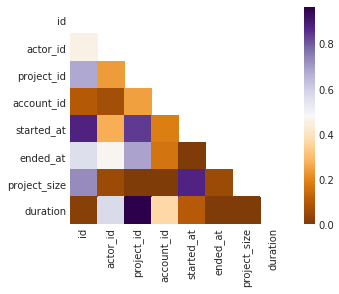

In [63]:
mask = np.zeros_like(pvals)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    p2 = sns.heatmap(pvals, mask=mask, square=True, cmap="PuOr")

In [64]:
rho, pval = stats.spearmanr(small)

rhos = pd.DataFrame(rho, columns=['id','actor_id','project_id','account_id','started_at','ended_at','project_size','duration'])
rhos = rhos.rename(index={0: 'id',1: 'actor_id',2: 'project_id',3: 'account_id',4: 'started_at',5: 'ended_at',6: 'project_size',7: 'duration'})
round(rhos, 3)

C:\Users\Kevin\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


,id,actor_id,project_id,account_id,started_at,ended_at,project_size,duration
id,1.000,0.038,0.021,-0.084,0.008,-0.030,0.018,-0.121
actor_id,0.038,1.000,-0.060,-0.093,0.056,0.037,0.097,0.029
project_id,0.021,-0.060,1.000,0.059,-0.010,-0.020,-0.278,-0.002
account_id,-0.084,-0.093,0.059,1.000,0.068,0.071,-0.187,0.046
started_at,0.008,0.056,-0.010,0.068,1.000,0.927,0.008,0.083
ended_at,-0.030,0.037,-0.020,0.071,0.927,1.000,0.099,0.341
project_size,0.018,0.097,-0.278,-0.187,0.008,0.099,1.000,0.356
duration,-0.121,0.029,-0.002,0.046,0.083,0.341,0.356,1.000


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text xticklabel objects>)

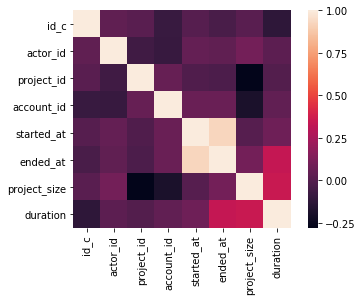

In [54]:
sns.heatmap(rhos, square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)

In [65]:
items = ['id','actor_id','project_id','account_id','started_at','ended_at','project_size','duration']
arr = []

for i in items:
    for j in items:
        if pvals.loc[i,j] <= 0.05 and (rhos.loc[i,j] > 0.5 or rhos.loc[i,j] < -0.5) and i != j and [j,i, pvals.loc[j,i], rhos.loc[j,i]] not in arr:
            arr.append([i,j, pvals.loc[i,j], rhos.loc[i,j]])
        

arr = pd.DataFrame(arr,columns=['1','2','P-Value','R'])
arr.sort_values('R', ascending = True)

,1,2,P-Value,R
0,started_at,ended_at,1.955306e-165,0.927212


#5 Using these collections, determine what are the main drivers (if any) of usage/duration growth for accounts.